In [53]:
import rasterio as rio
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import rasterio
import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress

import warnings
warnings.filterwarnings('ignore')

In [54]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
cmip6_models = ['bcc-csm2-mr', 'bcc-esm1', 'canesm5', \
                'kace-1-0-g', 'ipsl-cm6a-lr', 'miroc6', \
                'mri-esm2-0', 'noresm2-lm']

cmip6_lat = np.arange(-90, 90, 1.5)
cmip6_lon = np.arange(0, 360, 1.5)


In [56]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirEra5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirCMIP6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

In [57]:
era5_max_deciles = xr.open_dataset('%s/era5_tw_max_deciles.nc'%dirHeatData)
lat = era5_max_deciles.latitude.values
lon = era5_max_deciles.longitude.values

In [58]:
# client = Client(n_workers=2)
# tn_era5 = xr.open_mfdataset('%s/daily/tasmin_*.nc'%dirEra5)
# tn_era5 = tn_era5.sel(time=slice('1981', '2021'))
# tn_era5_mean = tn_era5.mean(dim='time')
# # tn_era5_mean.compute()
# tn_era5_mean.to_netcdf('era5_tasmin_mean.nc')

In [59]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
land_sea_mask = land_sea_mask.lsm.mean(dim='time')
land_sea_mask_binary = land_sea_mask > 0.1


In [76]:
# from datetime import datetime
# def add_time_dim(xda):
#     xda = xda.expand_dims(time = [datetime.now()])
#     return xda

# time_dim = pd.date_range("1981-01-01", "2020-12-31", freq="AS")
# era5_var_deciles = xr.open_mfdataset('deciles/tw/era5_tw_max_deciles_warm_season_*_new.nc', preprocess = add_time_dim, concat_dim='time')
# era5_var_deciles['time'] = time_dim
# era5_var_deciles = era5_var_deciles.chunk(chunks={"time": -1, "latitude": 50, "longitude": 50})
# era5_var_deciles = era5_var_deciles.chunk({"time": -1})
# era5_var_deciles = era5_var_deciles.chunk({"quantile": -1})


from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2019-12-31", freq="AS")
era5_var_deciles = xr.open_mfdataset('output/tran_on_tx_season/tran_on_tx_warm_season_*.nc', preprocess = add_time_dim, concat_dim='time')
# era5_var_deciles = era5_var_deciles.rename({'bin':'quantile'})
era5_var_deciles['time'] = time_dim
era5_var_deciles = era5_var_deciles.chunk(chunks={"time": -1, "latitude": 50, "longitude": 50})
era5_var_deciles = era5_var_deciles.chunk({"time": -1})
# era5_var_deciles = era5_var_deciles.chunk({"quantile": -1})

time_dim = pd.date_range("1981-01-01", "2020-12-31", freq="AS")
era5_var_deciles_et = xr.open_mfdataset('output/et_on_tx_season/et_on_tx_warm_season_*.nc', preprocess = add_time_dim, concat_dim='time')
# era5_var_deciles = era5_var_deciles.rename({'bin':'quantile'})
era5_var_deciles_et['time'] = time_dim
era5_var_deciles_et = era5_var_deciles_et.sel(time=slice('1981', '2019'))
era5_var_deciles_et = era5_var_deciles_et.chunk(chunks={"time": -1, "latitude": 50, "longitude": 50})
era5_var_deciles_et = era5_var_deciles_et.chunk({"time": -1})
# era5_var_deciles = era5_var_deciles.chunk({"quantile": -1})



In [77]:
era5_var_deciles

,Array,Chunk
Bytes,323.93 MB,780.00 kB
Shape,"(39, 721, 1440)","(39, 50, 50)"
Count,1899 Tasks,435 Chunks
Type,float64,numpy.ndarray


In [78]:
era5_var_deciles_et

,Array,Chunk
Bytes,323.93 MB,780.00 kB
Shape,"(39, 721, 1440)","(39, 50, 50)"
Count,1992 Tasks,435 Chunks
Type,float64,numpy.ndarray


In [79]:
era5_var_deciles = era5_var_deciles.rename({'evatc':'tran'})
era5_var_deciles_et = era5_var_deciles_et.rename({'e':'et'})

In [84]:
tet = era5_var_deciles.tran/era5_var_deciles_et.et
era5_var_deciles = tet

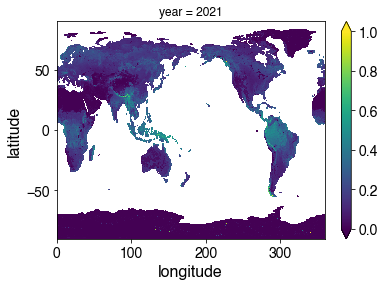

In [85]:
era5_var_deciles.mean(dim='time').plot(vmin=0, vmax=1)

In [86]:
land_sea_mask_binary = land_sea_mask_binary.broadcast_like(era5_var_deciles)
era5_var_deciles_masked = era5_var_deciles.where(land_sea_mask_binary)

In [67]:
# era5_var_deciles_masked = era5_var_deciles_masked.sel(quantile=np.arange(0, 101, 5)/100, method='nearest')

In [87]:
era5_var_deciles_masked
# era5_var_deciles_masked['ef'] = era5_var_deciles_masked['ef'].where(np.abs(era5_var_deciles_masked['ef']) <= 1)


,Array,Chunk
Bytes,323.93 MB,452.40 kB
Shape,"(39, 721, 1440)","(39, 29, 50)"
Count,10997 Tasks,841 Chunks
Type,float64,numpy.ndarray


In [88]:
def linregress_ufunc(x, y):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return slope, p_value



def apply_trend_and_pvalue(ds, time_dim='time', x_dim='longitude', y_dim='latitude', bin_dim='quantile'):
    # Extract the year information from the time coordinates
    time_years = ds[time_dim].dt.year.values
    unique_years = np.unique(time_years)
    
    # Broadcast unique_years along the time dimension
    unique_years_broadcasted = xr.DataArray(unique_years, dims=[time_dim], coords={time_dim: ds[time_dim]})
    
    trend, p_value = xr.apply_ufunc(
        linregress_ufunc,
        unique_years_broadcasted,
        ds,
        input_core_dims=[[time_dim], [time_dim]],
        output_core_dims=[[], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float]
    )

    trend = trend.rename("tet_on_warm_season_trend")
    p_value = p_value.rename("tet_on_warm_season_p_value")
    
    return xr.merge([trend, p_value])





In [89]:
# temperature_trend = apply_trend_and_pvalue(era5_var_deciles_masked["mx2t"])
tet_on_warm_season_trend = apply_trend_and_pvalue(era5_var_deciles_masked)

In [90]:
# evap_on_warm_season_tw_trend.to_netcdf('era5_evaporation_on_warm_season_tw_trends_by_decile_bootstrap.nc')

In [91]:
# trend_ds = xr.Dataset({"tw_trend_deciles": temperature_trend})

In [92]:
client = Client()

In [93]:
# with ProgressBar():
# temperature_trend.compute().to_netcdf("era5_tw_warm_season_trends_by_decile_new.nc")
tet_on_warm_season_trend.compute().to_netcdf("era5_tet_on_warm_season_trends.nc")
#     dask.array.store(trend_ds["tw_trend_deciles"].data, output_ds["tw_trend_deciles"].data, lock=False)